# Adding in our own transfer layer by hand with AlexNet

In [97]:
# Python > 3, TensorFlow > 1.0
import random
import tensorflow as tf
import numpy as np
import os
from scipy import ndimage
import matplotlib.pyplot as plt

%matplotlib inline

# Load in our previous exported model

In [98]:
graph = tf.Graph()
with graph.as_default():
    importer = tf.train.import_meta_graph('saved_models/alex_vars.meta')

sess = tf.Session(graph=graph)
importer.restore(sess, 'saved_models/alex_vars')

INFO:tensorflow:Restoring parameters from saved_models/alex_vars


## Get handle to second-to-last layer in pre-built model

In [99]:
fc7_op = graph.get_operation_by_name('fc7/relu')
fc7 = fc7_op.outputs[0]

In [100]:
fc7.get_shape()

TensorShape([Dimension(None), Dimension(4096)])

# Create new layer, attached to `fc7`

In [101]:
# Create new final layer
with graph.as_default():
    x = graph.get_operation_by_name('input').outputs[0]
    
    with tf.name_scope('transfer'):
        labels = tf.placeholder(tf.int32, [None])
        one_hot_labels = tf.one_hot(labels, 2)

        with tf.name_scope('cat_dog_final_layer'):
            weights = tf.Variable(tf.truncated_normal([4096, 2], stddev=0.001),
                                  name='final_weights')
            biases = tf.Variable(tf.zeros([2]), name='final_biases')
            logits = tf.nn.xw_plus_b(fc7, weights, biases, name='logits')

        prediction = tf.nn.softmax(logits, name='cat_dog_softmax')
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
        loss = tf.reduce_mean(cross_entropy, name='cat_dog_loss')

        global_step = tf.Variable(0, trainable=False, name='global_step')
        inc_step = global_step.assign_add(1)

        cat_dog_variables = [weights, biases]
        train = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step,
                                                                var_list=cat_dog_variables) 
    
    with tf.name_scope('accuracy'):
        label_prediction = tf.argmax(prediction, 1, name='predicted_label')
        correct_prediction = tf.equal(label_prediction, tf.argmax(one_hot_labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    
    init = tf.global_variables_initializer()

In [102]:
sess = tf.Session(graph=graph)
sess.run(init)

# Get our training file names

In [117]:
cat_files = [
    'data/dogs_and_cats/cats/' + f
    for 
    f
    in
    os.listdir('data/dogs_and_cats/cats')
]

dog_files = [
    'data/dogs_and_cats/dogs/' + f
    for 
    f
    in
    os.listdir('data/dogs_and_cats/dogs')
]

all_files = cat_files + dog_files

# Shuffle and split into training/validation

In [118]:
random.shuffle(all_files)

In [119]:
num_files = len(all_files)
valid_percentage = 0.3
split = int(num_files * valid_percentage)
valid_data = all_files[:split]
train_data = all_files[split:]

In [120]:
print('Number of training images: {}'.format(len(train_data)))
print('Number of validation images: {}'.format(len(valid_data)))

Number of training images: 4686
Number of validation images: 2007


# Create generator to give us batches of data

In [121]:
flip_left_right = True
random_crop = 1
random_scale = 1
random_brightness = 1
num_channels = 3
height = 227
width = 227
pixel_depth = 255.0

In [122]:
import ntpath

def get_batch(batch_size, data, max_epochs, should_distort=False):
    distort_graph = tf.Graph()
    with distort_graph.as_default():
        """
        From https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py
        """
        jpeg_name = tf.placeholder(tf.string, name='DistortJPGInput')
        jpeg_data = tf.read_file(jpeg_name)
        decoded_image = tf.image.decode_jpeg(jpeg_data, channels=3)
        resized_image = tf.image.resize_images(decoded_image, (height, width))
        decoded_image_as_float = tf.cast(decoded_image, dtype=tf.float32)
        decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
        margin_scale = 1.0 + (random_crop / 100.0)
        resize_scale = 1.0 + (random_scale / 100.0)
        margin_scale_value = tf.constant(margin_scale)
        resize_scale_value = tf.random_uniform(shape = (),
                                             minval=1.0,
                                             maxval=resize_scale)
        scale_value = tf.multiply(margin_scale_value, resize_scale_value)
        precrop_width = tf.multiply(scale_value, width)
        precrop_height = tf.multiply(scale_value, width)
        precrop_shape = tf.stack([precrop_height, precrop_width])
        precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
        precropped_image = tf.image.resize_bilinear(decoded_image_4d,
                                                  precrop_shape_as_int)
        precropped_image_3d = tf.squeeze(precropped_image, axis=[0])
        cropped_image = tf.random_crop(precropped_image_3d,
                                     [width, width,
                                      num_channels])
        if flip_left_right:
            flipped_image = tf.image.random_flip_left_right(cropped_image)
        else:
            flipped_image = cropped_image
        brightness_min = 1.0 - (random_brightness / 100.0)
        brightness_max = 1.0 + (random_brightness / 100.0)
        brightness_value = tf.random_uniform(shape = (),
                                           minval=brightness_min,
                                           maxval=brightness_max)
        brightened_image = tf.multiply(flipped_image, brightness_value)
        distort_result = tf.expand_dims(brightened_image, 0, name='DistortResult')

    distort_sess = tf.Session(graph=distort_graph)
    
    epoch = 0
    idx = 0
    while epoch < max_epochs: 
        batch = []
        labels = []
        for i in range(batch_size):
            if idx + i >= len(data):
                random.shuffle(data)
                epoch += 1
                idx = 0
            image_path = data[idx + i].encode()
            if should_distort:
                val = distort_sess.run(distort_result, 
                                       feed_dict={jpeg_name: image_path})
            else:
                val = distort_sess.run(resized_image, 
                                       feed_dict={jpeg_name: image_path})
            if b'dog' in ntpath.basename(image_path):
                labels.append(1)
            else:
                labels.append(0)
            batch.append(val)
        idx += batch_size
        yield batch, labels

In [123]:
sess.run(init)

## Quick save of our model to view later

In [124]:
writer = tf.summary.FileWriter('tensorboard/alexnet_retrain', graph=graph)
writer.close()

# Train our model!

In [125]:
for data_batch, label_batch in get_batch(32, train_data, 1, should_distort=True):
    data_batch = np.squeeze(data_batch)
    feed_dict = {x: data_batch, labels: label_batch}
    err, acc, step, _ = sess.run([loss, accuracy, inc_step, train],
                            feed_dict=feed_dict)
    if step % 50 == 0:
        print("Step: {}\t Accuracy: {}\t Error: {}".format(step, acc, err))

Step: 50	 Accuracy: 0.875	 Error: 0.19469791650772095
Step: 100	 Accuracy: 0.875	 Error: 0.18326984345912933
Step: 150	 Accuracy: 0.96875	 Error: 0.09202038496732712
Step: 200	 Accuracy: 1.0	 Error: 0.0273353923112154
Step: 250	 Accuracy: 0.90625	 Error: 0.2447725087404251


# Validate

In [126]:
def check_accuracy(valid_data):
    batch_size = 50
    num_correct = 0
    total = len(valid_data)
    i = 0
    for data_batch, label_batch in get_batch(batch_size, valid_data, 1):
        feed_dict = {x: data_batch, labels: label_batch}
        correct_guesses = sess.run(correct_prediction,
                                   feed_dict=feed_dict)
        num_correct += np.sum(correct_guesses)
        i += batch_size
        if i % (batch_size * 10) == 0:
            print('\tIntermediate accuracy: {}'.format((float(num_correct) / float(i))))
    acc = num_correct / float(total)
    print('\nAccuracy: {}'.format(acc))

In [127]:
check_accuracy(valid_data)

	Intermediate accuracy: 0.928
	Intermediate accuracy: 0.934
	Intermediate accuracy: 0.9393333333333334
	Intermediate accuracy: 0.9435

Accuracy: 0.9641255605381166


# Once again, let's inspect for fun

In [128]:
def spot_check():
    filename = random.choice(valid_data)
    image = ndimage.imread(filename)
    feed_dict = {x: [image]}
    guess = sess.run(label_prediction, feed_dict=feed_dict)
    if guess[0] == 1:
        print('Guess: dog')
    else:
        print('Guess: cat')
    plt.imshow(image)
    plt.show()

Guess: dog


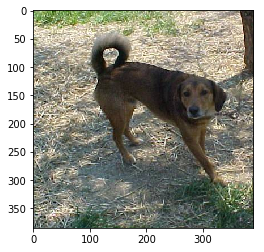

In [129]:
spot_check()